In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random
import os
import time
from ta import add_all_ta_features

In [3]:
# load stocks and index funds
l1=os.listdir('stocks')
l2=os.listdir('etfs')

# set up GPU
device=torch.device('cuda:0')

In [5]:
def lin_reg(df):
    """
    Perform feature neutralization using linear regression
    
    This function fits a linear model to predict the first 5 columns
    of the dataframe using the remaining columns as features. It then
    uses this model to create a 'neutralized' version of the first 5 columns.
    
    Args:
    df (numpy.array): Input data array
    
    Returns:
    numpy.array: Array of neutralized values for the first 5 columns
    """
    reg = LinearRegression()
    reg.fit(df[:50, 6:], df[:50, :5])
    return_arr = list(reg.predict(df[:51, 6:]))
    
    for i in range(50, df.shape[0]-1):
        reg.fit(df[i-50:i-1, 6:], df[i-49:i, :5])
        return_arr.append(reg.predict(np.expand_dims(df[i+1, 6:], 0))[0])
    return np.array(return_arr)

In [6]:
def raw_data(path):
    """
    Load and preprocess raw data from a CSV file
    
    This function reads a CSV file, selects specific columns,
    removes any rows with NaN values, and adds technical analysis features.
    
    Args:
    path (str): Path to the CSV file
    
    Returns:
    numpy.array: Preprocessed data array
    """
    df = pd.read_csv(path).filter(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
    df = df.dropna()
    df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    return np.array(df)

def generate(path):
    """
    Generate processed data for model input
    
    This function loads raw data, applies feature neutralization,
    calculates returns, and scales the data.
    
    Args:
    path (str): Path to the CSV file
    
    Returns:
    tuple: Processed data array and various scaling factors
    """
    df = raw_data(path)
    neutralized = lin_reg(df)
    df[:, :5] -= neutralized
    df = df[:-1] - df[1:]  # Calculate returns
    
    # Scale price data
    transprices = RobustScaler().fit(df[:, :5])
    df[:, :5] = transprices.transform(df[:, :5])
    maxprice = np.max(np.abs(df[:, :5]))
    maxvol = np.max(np.abs(df[:, 5]))
    df[:, :5] /= maxprice
    df[:, 5] /= maxvol
    
    # Scale technical indicators
    for x in range(6, df.shape[1]):
        transinc = RobustScaler().fit(df[:, x].reshape(-1, 1))
        df[:, x] = transinc.transform(df[:, x].reshape(-1, 1))[:, 0]
    df[:, 6:] /= np.max(np.abs(df[:, 6:]), 0)
    
    # Replace any remaining NaN or inf values
    np.nan_to_num(df, False, 0, 1, -1)
    
    return df, maxprice, maxvol, transprices, neutralized

In [7]:
# Shuffle stock and ETF lists for random selection
random.shuffle(l1)
random.shuffle(l2)

# Select the first ETF as the test data
test_path = 'etfs/' + l2[0]

# Perform Fast Fourier Transform (FFT) analysis on close prices
close_prices = raw_data(test_path)[:50][:, 3]
fft_result = torch.fft.fft(torch.Tensor(close_prices))

# Calculate frequency spectrum
frequencies = torch.fft.fftfreq(len(close_prices))

# Calculate amplitude spectrum
amplitude = np.abs(fft_result)

# Create a DataFrame with frequency and amplitude data
df1 = pd.DataFrame({"freq": frequencies, "amp": amplitude}, columns=["freq", "amp"])
df1 = df1.loc[df1["freq"] > 0]  # Keep only positive frequencies

frequencies = df1["freq"]
amplitude = df1["amp"]

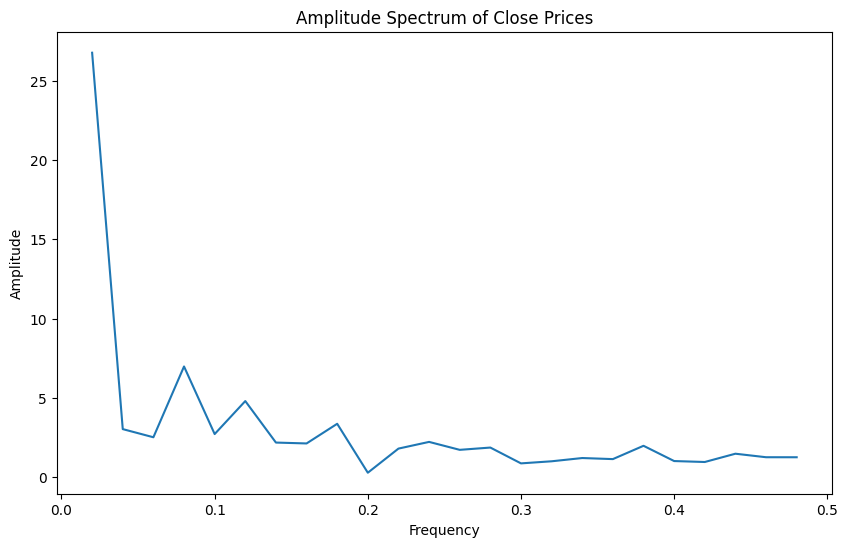

In [8]:
# Plot the amplitude spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, amplitude)
plt.title('Amplitude Spectrum of Close Prices')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

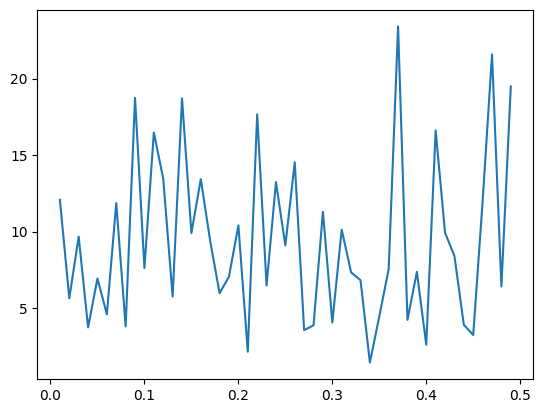

In [9]:
# Generate random input data
x = torch.randn(100)

# Perform FFT on the input data
X = torch.fft.fft(x)

# Create a modified frequency spectrum
# This step appears to be doubling the magnitude of the first half of the spectrum,
# zeroing out the middle frequencies, and preserving the second half
XX = 2 * torch.tensor(list(X[:50]) + [X[50]/2] + list(np.zeros(99)) + [X[50]/2] + list(X[51:]), dtype=torch.complex64)

# Perform inverse FFT on the modified spectrum
xx = torch.fft.ifft(XX)

# Calculate the frequency array
freq = np.array(torch.fft.fftfreq(100))

# Plot the amplitude spectrum of the original FFT result
plt.plot(freq[freq>0], np.abs(X)[freq>0])

#plt.plot(np.arange(200)/200,xx)
#plt.plot(np.arange(200)/200,xx,'g.')
#plt.plot(np.arange(100)/100,x,'r.')

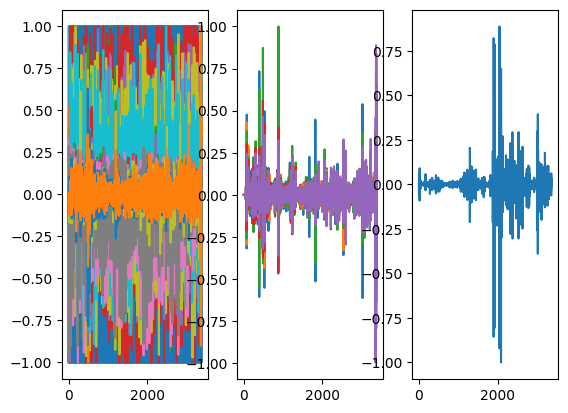

In [10]:
# Generate processed data from the test path
df, maxprice, maxvol, transa, neutralized = generate(test_path)

# Create a figure with three subplots to visualize the processed data
fig, ax = plt.subplots(1, 3)
ax[0].plot(df)  # Plot all columns
ax[1].plot(df[:, :5])  # Plot first 5 columns (likely price data)
ax[2].plot(df[:, 5])  # Plot 6th column (likely volume data)
plt.show()

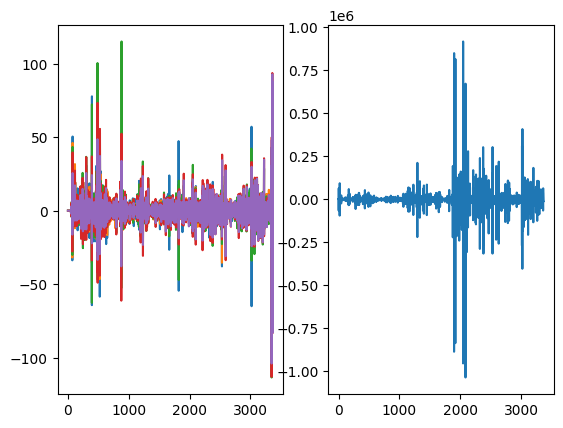

In [11]:
def restorePreds(d, maxprice, maxvol, transa):
    """
    Restore the scaled predictions to their original scale
    
    Args:
    d (numpy.array): Scaled data
    maxprice (float): Maximum price used for scaling
    maxvol (float): Maximum volume used for scaling
    transa (sklearn.preprocessing.RobustScaler): Scaler used for price data
    
    Returns:
    numpy.array: Data restored to original scale
    """
    df = d.copy()
    df[:, :5] = transa.inverse_transform(df[:, :5] * maxprice)
    df[:, 5] = df[:, 5] * maxvol
    return df

# Restore the processed data to its original scale
df = restorePreds(df, maxprice, maxvol, transa)

# Plot the restored data
fig, ax = plt.subplots(1, 2)
ax[0].plot(df[:, :5])  # Plot restored price data
ax[1].plot(df[:, 5])  # Plot restored volume data
plt.show()

In [12]:
def create(dataset, lback, lforward=1):
    """
    Create input-output pairs for sequence prediction
    
    Args:
    dataset (numpy.array): Input data
    lback (int): Number of lookback steps
    lforward (int): Number of steps to predict forward (default is 1)
    
    Returns:
    tuple: (X, y) where X is the input sequences and y is the target sequences
    """
    X, y = [], []
    for i in range(len(dataset) - lback - lforward + 1):
        X.append(np.array(dataset[i:i+lback]))
        y.append(np.array(dataset[i+1:i+lback+lforward]))
    return torch.tensor(np.array(X)).float(), torch.tensor(np.array(y)).float()

In [13]:
# Set the number of lookback steps
lback = 50

# Create input-output pairs for training
X_train, y_train = create(df, lback=lback)

PHASE 1a1: LSTM PREDICTION

In [14]:
import torch.nn as nn

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=92, hidden_size=200, num_layers=2, dropout=0.1, batch_first=True)
        self.l1 = nn.Linear(200, 92)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.l1(x)
        return x

In [15]:
# Instantiate the model and move it to the specified device (GPU if available)
model = LSTMModel()
model.to(device)

LSTMModel(
  (lstm): LSTM(92, 200, num_layers=2, batch_first=True, dropout=0.1)
  (l1): Linear(in_features=200, out_features=92, bias=True)
)

In [19]:
# Define loss functions
def l2loss(y_pred, y):
    return torch.mean(torch.square(y_pred - y))

def signloss(y_pred, y):
    return -torch.mean(torch.clip(y[:,:,:5] * y_pred[:,:,:5], 0) * torch.abs(y[:,:,:5]))

def extloss(y_pred, y):
    return torch.square(torch.mean(torch.abs(y) - torch.abs(y_pred)))

def lstmloss(y_pred, y):
    l2 = l2loss(y_pred, y) * 3
    sign = signloss(y_pred, y)
    ext = extloss(y_pred, y) * 3
    return torch.clip(l2 * (1 + sign + ext), max=0.5)

In [20]:
# Set learning rate
lr = 1e-2

# Define training function
def train(n_epochs, dl, lforward=1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr/lforward)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr/100/lforward, max_lr=lr/lforward, step_size_up=10000, mode="triangular2", cycle_momentum=False)
    for i in range(n_epochs):
        for X, y in dl:
            y = y.to(device)
            logits = 0
            y_pred = model(X.to(device))
            logits += lstmloss(y_pred, y[:,:lback])
            for j in range(1, lforward):
                y_pred = model(y_pred)
                logits += lstmloss(y_pred, y[:,j:j+lback])
            logits = logits / lforward
            optimizer.zero_grad()
            logits.backward()
            optimizer.step()
            scheduler.step()
    print(logits)
    torch.save(model.state_dict(), 'lstmmodel.pt')

In [21]:
len(l2)

2120

In [23]:
# Set model to training mode
model.train()
lforward = 1
counter = 0

# Train the model on each ETF dataset
for i in l2:
    a = 'etfs/' + i
    df, _, _, _, _ = generate(a)
    X_train, y_train = create(df, lback=lback, lforward=lforward)
    dl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=64)
    train(50, dl, lforward=lforward)
    counter += 1
    print(f"==== Loop Cycle {counter}/{len(l2)} Complete ====")

tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1/2120 Complete ====
tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 2/2120 Complete ====
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 3/2120 Complete ====
tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 4/2120 Complete ====
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 5/2120 Complete ====
tensor(0.0072, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 6/2120 Complete ====
tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 7/2120 Complete ====
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 8/2120 Complete ====
tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 9/2120 Complete ====
tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 10/2120 Complete ====
tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cyc

c:\Users\edwin\OneDrive\Documents\_School\CS\DailyPredictions\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 528/2120 Complete ====
tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 529/2120 Complete ====
tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 530/2120 Complete ====
tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 531/2120 Complete ====
tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 532/2120 Complete ====
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 533/2120 Complete ====
tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 534/2120 Complete ====
tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 535/2120 Complete ====
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 536/2120 Complete ====
tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 537/2120 Complete ====
tensor(0.0048, device='cuda:0', grad_fn=<DivBackwa

c:\Users\edwin\OneDrive\Documents\_School\CS\DailyPredictions\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 579/2120 Complete ====
tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 580/2120 Complete ====
tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 581/2120 Complete ====
tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 582/2120 Complete ====
tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 583/2120 Complete ====
tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 584/2120 Complete ====
tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 585/2120 Complete ====
tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 586/2120 Complete ====
tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 587/2120 Complete ====
tensor(0.0238, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 588/2120 Complete ====
tensor(0.0045, device='cuda:0', grad_fn=<DivBackwa

c:\Users\edwin\OneDrive\Documents\_School\CS\DailyPredictions\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 617/2120 Complete ====
tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 618/2120 Complete ====
tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 619/2120 Complete ====
tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 620/2120 Complete ====
tensor(0.0136, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 621/2120 Complete ====
tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 622/2120 Complete ====
tensor(0.0138, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 623/2120 Complete ====
tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 624/2120 Complete ====
tensor(0.0114, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 625/2120 Complete ====
tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 626/2120 Complete ====
tensor(0.0657, device='cuda:0', grad_fn=<DivBackwa

c:\Users\edwin\OneDrive\Documents\_School\CS\DailyPredictions\.venv\Lib\site-packages\ta\volume.py:335: RuntimeWarning: overflow encountered in scalar multiply
  self._nvi.iloc[i] = self._nvi.iloc[i - 1] * (1.0 + price_change.iloc[i])


tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 755/2120 Complete ====
tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 756/2120 Complete ====
tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 757/2120 Complete ====
tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 758/2120 Complete ====
tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 759/2120 Complete ====
tensor(0.0142, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 760/2120 Complete ====
tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 761/2120 Complete ====
tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 762/2120 Complete ====
tensor(0.0146, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 763/2120 Complete ====
tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 764/2120 Complete ====
tensor(0.0242, device='cuda:0', grad_fn=<DivBackwa

c:\Users\edwin\OneDrive\Documents\_School\CS\DailyPredictions\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 792/2120 Complete ====
tensor(0.0148, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 793/2120 Complete ====
tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 794/2120 Complete ====
tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 795/2120 Complete ====
tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 796/2120 Complete ====
tensor(0.0255, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 797/2120 Complete ====
tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 798/2120 Complete ====
tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 799/2120 Complete ====
tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 800/2120 Complete ====
tensor(0.0399, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 801/2120 Complete ====
tensor(0.0299, device='cuda:0', grad_fn=<DivBackwa

c:\Users\edwin\OneDrive\Documents\_School\CS\DailyPredictions\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 876/2120 Complete ====
tensor(0.0188, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 877/2120 Complete ====
tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 878/2120 Complete ====
tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 879/2120 Complete ====
tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 880/2120 Complete ====
tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 881/2120 Complete ====
tensor(0.0114, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 882/2120 Complete ====
tensor(0.0433, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 883/2120 Complete ====
tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 884/2120 Complete ====
tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 885/2120 Complete ====
tensor(0.0073, device='cuda:0', grad_fn=<DivBackwa

C:\Users\edwin\AppData\Local\Temp\ipykernel_3112\512763855.py:21: RuntimeWarning: invalid value encountered in divide
  df[:,6:] /= np.max(np.abs(df[:,6:]),0)


tensor(0.0546, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1381/2120 Complete ====
tensor(0.0092, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1382/2120 Complete ====
tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1383/2120 Complete ====


C:\Users\edwin\AppData\Local\Temp\ipykernel_3112\512763855.py:21: RuntimeWarning: invalid value encountered in divide
  df[:,6:] /= np.max(np.abs(df[:,6:]),0)


tensor(0.1380, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1384/2120 Complete ====
tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1385/2120 Complete ====
tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1386/2120 Complete ====
tensor(0.0193, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1387/2120 Complete ====
tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1388/2120 Complete ====
tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1389/2120 Complete ====
tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1390/2120 Complete ====
tensor(0.0108, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1391/2120 Complete ====
tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1392/2120 Complete ====
tensor(0.0150, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1393/2120 Complete ====
tensor(0.0065, device='cuda:0', grad_fn=

C:\Users\edwin\AppData\Local\Temp\ipykernel_3112\512763855.py:21: RuntimeWarning: invalid value encountered in divide
  df[:,6:] /= np.max(np.abs(df[:,6:]),0)


tensor(0.0613, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1400/2120 Complete ====
tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1401/2120 Complete ====
tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1402/2120 Complete ====
tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1403/2120 Complete ====
tensor(0.0156, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1404/2120 Complete ====
tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1405/2120 Complete ====
tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1406/2120 Complete ====
tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1407/2120 Complete ====
tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1408/2120 Complete ====
tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1409/2120 Complete ====
tensor(0.0753, device='cuda:0', grad_fn=

c:\Users\edwin\OneDrive\Documents\_School\CS\DailyPredictions\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
C:\Users\edwin\AppData\Local\Temp\ipykernel_3112\512763855.py:21: RuntimeWarning: invalid value encountered in divide
  df[:,6:] /= np.max(np.abs(df[:,6:]),0)


tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1622/2120 Complete ====
tensor(0.0171, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1623/2120 Complete ====
tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1624/2120 Complete ====
tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1625/2120 Complete ====
tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1626/2120 Complete ====
tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1627/2120 Complete ====
tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1628/2120 Complete ====
tensor(0.0243, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1629/2120 Complete ====
tensor(0.0722, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1630/2120 Complete ====
tensor(0.0186, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1631/2120 Complete ====
tensor(0.0046, device='cuda:0', grad_fn=

C:\Users\edwin\AppData\Local\Temp\ipykernel_3112\512763855.py:21: RuntimeWarning: invalid value encountered in divide
  df[:,6:] /= np.max(np.abs(df[:,6:]),0)


tensor(0.0727, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1903/2120 Complete ====
tensor(0.0109, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1904/2120 Complete ====
tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1905/2120 Complete ====
tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1906/2120 Complete ====
tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1907/2120 Complete ====
tensor(0.0111, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1908/2120 Complete ====
tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1909/2120 Complete ====
tensor(0.0562, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1910/2120 Complete ====
tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1911/2120 Complete ====
tensor(0.0107, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1912/2120 Complete ====
tensor(0.0151, device='cuda:0', grad_fn=

c:\Users\edwin\OneDrive\Documents\_School\CS\DailyPredictions\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1919/2120 Complete ====
tensor(0.0277, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1920/2120 Complete ====
tensor(0.0080, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1921/2120 Complete ====
tensor(0.0121, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1922/2120 Complete ====
tensor(0.0161, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1923/2120 Complete ====
tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1924/2120 Complete ====
tensor(0.0259, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1925/2120 Complete ====
tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1926/2120 Complete ====
tensor(0.0200, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1927/2120 Complete ====
tensor(0.0168, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1928/2120 Complete ====
tensor(0.0130, device='cuda:0', grad_fn=

c:\Users\edwin\OneDrive\Documents\_School\CS\DailyPredictions\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1954/2120 Complete ====
tensor(0.0160, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1955/2120 Complete ====
tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1956/2120 Complete ====
tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1957/2120 Complete ====
tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1958/2120 Complete ====
tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1959/2120 Complete ====
tensor(0.0411, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1960/2120 Complete ====
tensor(0.0102, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1961/2120 Complete ====
tensor(0.0136, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1962/2120 Complete ====
tensor(0.0092, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 1963/2120 Complete ====
tensor(0.0083, device='cuda:0', grad_fn=

c:\Users\edwin\OneDrive\Documents\_School\CS\DailyPredictions\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 2117/2120 Complete ====
tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 2118/2120 Complete ====
tensor(0.0105, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 2119/2120 Complete ====
tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)
==== Loop Cycle 2120/2120 Complete ====


PHASE 1a2: LSTM STAGE 2 (>1 PREDICTION)

In [24]:
'''model.train()
random.shuffle(l1);random.shuffle(l2)
for i in l2[:100]:
    a='etfs/'+i
    df,_,_,_,_=generate(a)
    X_train,y_train=create(df,lback=lback,lforward=10)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(5,dl,10)'''

"model.train()\nrandom.shuffle(l1);random.shuffle(l2)\nfor i in l2[:100]:\n    a='etfs/'+i\n    df,_,_,_,_=generate(a)\n    X_train,y_train=create(df,lback=lback,lforward=10)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(5,dl,10)"

In [25]:
# Load the trained model
model.load_state_dict(torch.load('lstmmodel.pt'))


C:\Users\edwin\AppData\Local\Temp\ipykernel_3112\2978307079.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstmmodel.pt'))


<All keys matched successfully>

In [26]:
test_path='etfs/'+random.choice(l2)
#test_path='etfs/'+'SPY.csv'
print(test_path)

etfs/DGL.csv


In [27]:
# Set model to evaluation mode
model.eval() #NOT EVAL IN FINAL PREDICTIONS
# Generate test data
df, a, b, transprices, neutralized = generate(test_path)
X_test, y_test = create(df, lback=lback)
dl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), shuffle=False, batch_size=1)

# Make predictions
qwer = True
for X, y in dl:
    if qwer:
        predicted = list(X.detach().numpy()[0])
        qwer = False
    predicted.append(model(X.to(device))[0][-1].detach().cpu().numpy())

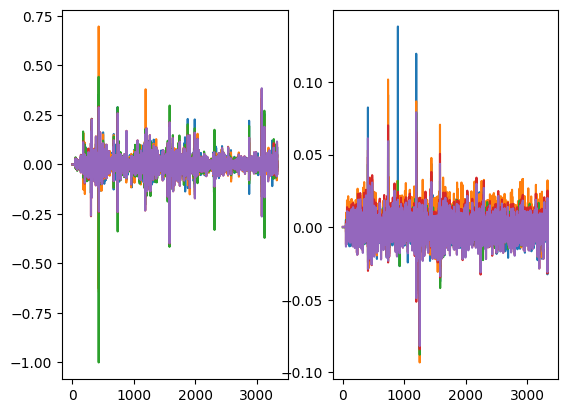

In [28]:
# Original data and predictions
fig,ax=plt.subplots(1,2)
ax[0].plot(df[:,:5])
ax[1].plot(np.array(predicted)[:,:5])
plt.show()

(3333, 6)
[array([ 23.96999931,  24.12000084,  23.96999931,  24.12000084,
        22.47920227, 900.        ])]


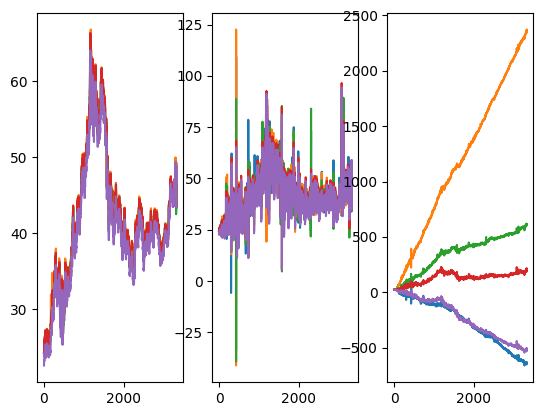

In [29]:
# Load and process test data
test_data = np.array(pd.read_csv(test_path).filter(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']))
print(test_data.shape)

# Plot original data, 1-day predictions, and cumulative predictions
fig, ax = plt.subplots(1, 3)
ax[0].plot(test_data[1:, :5])  # original

predicted = np.array(predicted)
predicted = restorePreds(predicted, a, b, transprices)
test2 = predicted[:, :5] + neutralized[:-1]
ax[1].plot(test2[1:-1])  # 1-day predictions

testult = [test_data[0]]
for i in range(predicted.shape[0]):
    testult.append(np.sum(predicted[:i+1], axis=0)[:6])
testult = np.array(testult)[:-1, :5] + neutralized[:-1]
ax[2].plot(np.array(testult)[1:-1, :5])  # cumulative predictions


In [30]:
# Evaluate model performance
def test_prep(arr):
    a = arr.copy()
    a /= np.max(np.abs(a)) + 1
    a = a[:-1] - a[1:]
    return a

test_data1 = test_prep(test_data[:-1, :5])  # original
test_data2 = test_prep(test2[:, :5])  # predictions

# Calculate performance metrics
pp = np.sum(np.ceil(test_data1))
pn = np.sum(np.ceil(-test_data1))
p = np.sum(np.ceil(test_data2))
n = np.sum(np.ceil(-test_data2))
tp = np.sum(np.ceil(test_data1) * np.ceil(test_data2))
tn = np.sum(np.ceil(-test_data1) * np.ceil(-test_data2))
recall = tp / p
precision = tp / pp
print('recall: ', recall)
print('precision: ', precision)
print('acc: ', (tp + tn) / (p + n))
print('f1: ', 2 * recall * precision / (recall + precision))

recall:  0.4783748361730013
precision:  0.5151398511675648
acc:  0.5037526268387872
f1:  0.4960770989065299


Naive returns

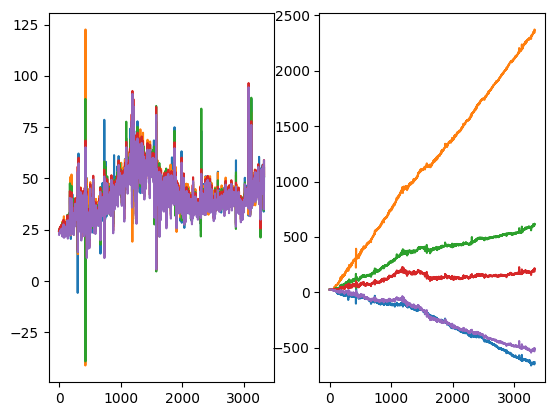

In [31]:
# Plot "naive" predictions and cumulative predictions
f, ax = plt.subplots(1, 2)
ax[0].plot(test2[1:-1])
ax[1].plot(np.array(testult)[1:-1, :5])

(3332, 5) (3332, 5)


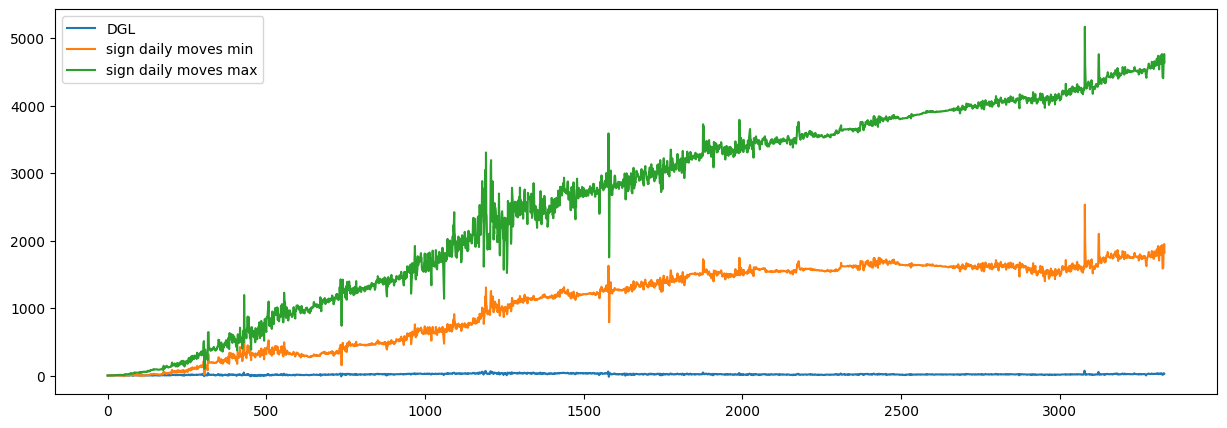

In [32]:
print(test2.shape, testult.shape)
# 3 is close
# Plot returns based on different trading strategies
plt.figure(figsize=(15, 5))
plt.plot(test2[1:-1, 3] - test2[0, 3], label=test_path.split('/')[1][:-4])
returns = [[], []]
init_c_min = 100
init_c_max = 100
init_s_min = 0
init_s_max = 0
for i in range(1,testult.shape[0]):
    if testult[i,3]-testult[i-1,3]>0:
        if init_c_min>=test2[i-1,1]:
            init_c_min-=test2[i-1,1]; init_s_min+=1
        if init_c_max>=test2[i-1,2]:
            init_c_max-=test2[i-1,2]; init_s_max+=1
    else:
        if init_s_min>0:
            init_c_min+=test2[i-1,2]; init_s_min-=1
        if init_s_max>0:
            init_c_max+=test2[i-1,1]; init_s_max-=1
    returns[0].append(init_c_min+init_s_min*test2[i-1,3]-100)
    returns[1].append(init_c_max+init_s_max*test2[i-1,3]-100)
plt.plot(returns[0], label='sign daily moves min')
plt.plot(returns[1], label='sign daily moves max')
plt.plot()
plt.legend()
plt.show()

PHASE 1b1: LGBM

In [33]:
%pip install lightgbm

In [34]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [36]:
# Load and preprocess the data
p_data = pd.read_csv(test_path).filter(['Open','High','Low','Close','Adj Close','Volume'])
p_data, _, _, _, _ = generate(test_path)
p_data = pd.DataFrame(p_data, columns=np.arange(p_data.shape[1]))
p_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
count,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,...,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000
mean,0.000010,0.000001,-0.000003,0.000227,0.000214,-0.000002,-0.001796,0.000636,0.000492,0.000162,...,0.005174,0.006620,0.001880,-0.024598,-0.026313,-0.013367,-0.003244,-0.001264,-0.001328,0.002896
std,0.035941,0.038675,0.040142,0.034375,0.034271,0.045388,0.082878,0.035385,0.085966,0.038651,...,0.143459,0.184605,0.121034,0.103547,0.146010,0.111225,0.083037,0.119371,0.125149,0.106284
min,-0.506839,-0.645290,-1.000000,-0.399299,-0.398655,-0.976473,-1.000000,-0.317839,-0.770186,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.764889,-0.998953,-0.998836,-0.744493
25%,-0.012321,-0.012453,-0.012486,-0.012022,-0.012016,-0.003807,-0.011451,-0.005423,-0.022419,-0.003398,...,-0.075361,-0.105409,-0.065770,-0.037116,-0.079953,-0.033428,-0.018988,-0.066794,-0.069986,-0.048458
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000107,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.012222,0.012090,0.012058,0.012522,0.012527,0.004363,0.010060,0.006266,0.022057,0.003451,...,0.079931,0.106852,0.064930,0.023534,0.064786,0.033224,0.009955,0.067486,0.070820,0.052863
max,0.432387,0.696521,0.442487,0.379333,0.384758,1.000000,0.941907,1.000000,1.000000,0.697865,...,0.976459,0.985292,0.860343,0.107274,0.257527,0.314619,1.000000,1.000000,1.000000,1.000000


In [37]:
total_start_time = time.time()

for col in p_data.columns:
    # Record start time for the column
    start_time = time.time()
    
    # Load data
    X = pd.DataFrame(p_data)
    y = pd.Series(p_data[col])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1,
    }

    # Train the model
    num_round = 100
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=50)])

    # Make predictions
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Record end time for the column
    end_time = time.time()
    column_runtime = end_time - start_time
    
    print(f'===== Column "{col}" =====')
    print(f'Runtime: {column_runtime:.5f}s')
    print(f'RMSE: {rmse}')

# Calculate total runtime
total_end_time = time.time()
total_runtime = total_end_time - total_start_time
print(f'\nTotal runtime: {total_runtime:.5f}s')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's rmse: 0.0133834
===== Column "0" =====
Runtime: 0.13893s
RMSE: 0.013383352864342316
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 0.00660005
===== Column "1" =====
Runtime: 0.11574s
RMSE: 0.0066000530590082105
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's rmse: 0.00436644
===== Column "2" =====
Runtime: 0.12604s
RMSE: 0.004366437087018026
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's rmse: 0.00586852
===== Column "3" =====
Runtime: 0.13049s
RMSE: 0.005868518960825189
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[72]	valid_0's rmse: 0.00582326
===== Column "4" =====
Runtime: 0.14145s
RMSE: 0.